### Import libraries

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from pylab import imread,subplot,imshow,show
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow
from tensorflow import keras
from tensorflow.keras import optimizers, layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator  

### Train, validation and test directories

In [2]:
base_dir = 'data/grocery_store_dataset'

train_dir =  os.path.join(base_dir, 'train/Dairy')
validation_dir =  os.path.join(base_dir, 'val/Dairy')
test_dir =  os.path.join(base_dir, 'test/Dairy')

print('Total number of training dairy images:', sum(len(files) for _, _, files in os.walk(train_dir)))
print('Total number of validation dairy images:', sum(len(files) for _, _, files in os.walk(validation_dir)))
print('Total number of test dairy images:', sum(len(files) for _, _, files in os.walk(test_dir)))

dairy_classes=[]
for root, subdirectories, files in os.walk(train_dir):
    for subdirectory in subdirectories:
        dairy_classes.append(subdirectory)

Total number of training dairy images: 1218
Total number of validation dairy images: 162
Total number of test dairy images: 378


### Display dataset images

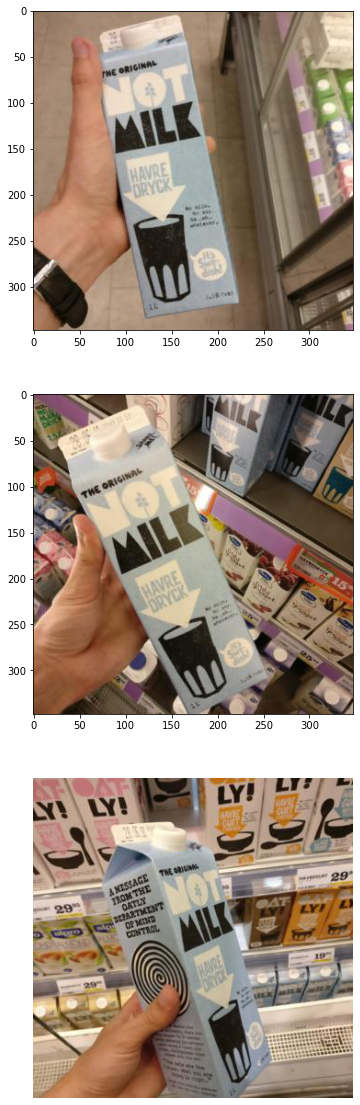

In [3]:
multiple_images = glob('grocery_store_dataset/train/Dairy/Oatly-Oat-Milk/**')
random_samples = random.sample(multiple_images, 3)

fig, ax = plt.subplots(3, 1,figsize=(20,20))
for i in range(3):
    ax[i].imshow(imread(random_samples[i])), plt.axis('off')

### Data preprocessing / augmentation

In [4]:
train_generator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True)

train_dataset = train_generator.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

test_dataset = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

validation_dataset = ImageDataGenerator(rescale=1./255).flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 1218 images belonging to 31 classes.
Found 378 images belonging to 31 classes.
Found 162 images belonging to 31 classes.


### Model configuration

In [5]:
vgg19_model = VGG19(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model.trainable = False

model = Sequential()

for layer in vgg19_model.layers:
    model.add(layer)
    
for layer in model.layers[-2:]:
    layer.trainable=True

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(31, activation='softmax'))


model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

2022-03-17 16:08:22.485348: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

### Model fitting

In [6]:
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01,patience= 5)
checkpoint = callbacks.ModelCheckpoint('./dairy.h5', monitor='val_accuracy', save_best_only=True)
callbacks=[early_stopping, checkpoint]

history = model.fit(train_dataset,
                    steps_per_epoch=48,
                    epochs=1,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

14/48 [=======>......................] - ETA: 4:12 - loss: 3.7634 - accuracy: 0.0486

KeyboardInterrupt: 

### Saving the model

In [ ]:
model.save('dairy_model.h5')

### Plotting the results

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, 1), history.history['loss'], label='train')
plt.plot(np.arange(0, 1), history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, 1), history.history['accuracy'], label='train')
plt.plot(np.arange(0, 1), history.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

### Prediction

In [ ]:
base_pred = model.predict(test_dataset)
base_pred = base_pred.argmax(axis=1)

print(classification_report(test_dataset.classes, base_pred, target_names=dairy_classes))